In [1]:
# experiment.py
import numpy as np
import matplotlib.pyplot as plt
import config
from preprocessing import load_and_preprocess
from kde import CustomKDE

In [2]:
def run_experiments():
    # 1. Setup Data
    print("Loading images for experiment...")
    # We use the same preprocessing as before
    _, bg_features = load_and_preprocess(config.BG_IMAGE_PATH, config.IMG_SIZE, config.FEATURE_TYPE)
    _, test_features = load_and_preprocess(config.TEST_IMAGE_PATH, config.IMG_SIZE, config.FEATURE_TYPE)

    # 2. Define Parameters to Experiment With
    # We will test 3 kernels and 3 different bandwidths
    kernels = ['gaussian', 'uniform', 'triangular']
    bandwidths = [0.05, 0.2, 0.8] 
    
    # Note on Bandwidths (assuming normalized data [0,1]):
    # 0.05 = Very narrow (sensitive to small color changes)
    # 0.2  = Moderate (balanced)
    # 0.8  = Wide (very smooth, might merge object with background)

    # 3. Setup Visualization Grid
    rows = len(kernels)
    cols = len(bandwidths)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
    fig.suptitle(f"KDE Foreground Detection Experiments\nThreshold: {config.THRESHOLD}", fontsize=16)

    print(f"Starting Grid Search: {rows} Kernels x {cols} Bandwidths...")

    # 4. Run Loops
    for i, kernel_type in enumerate(kernels):
        for j, h in enumerate(bandwidths):
            print(f"Testing: Kernel={kernel_type}, Bandwidth={h}...")
            
            # Initialize Model
            kde = CustomKDE(kernel=kernel_type, bandwidth=h)
            
            # Fit (Use a small sample ratio for speed during experimentation)
            kde.fit(bg_features, sample_ratio=0.05)
            
            # Predict
            densities = kde.predict(test_features)
            
            # Reshape to image dimensions
            density_map = densities.reshape(config.IMG_SIZE[1], config.IMG_SIZE[0])
            print(density_map.min(), density_map.max(), density_map.mean())

            # scale density map to 1 to 100
            density_map = (density_map - density_map.min()) / (density_map.max() - density_map.min()) * 100
            
            # Create Mask (Foreground = Density < Threshold)
            # Note: In a rigorous experiment, you might tune the threshold per bandwidth,
            # but keeping it constant highlights how bandwidth affects density magnitude.
            mask = density_map < config.THRESHOLD

            # Plotting
            ax = axes[i, j]
            ax.imshow(mask, cmap='gray')
            ax.set_title(f"K={kernel_type}, h={h}")
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

Loading images for experiment...
Starting Grid Search: 3 Kernels x 3 Bandwidths...
Testing: Kernel=gaussian, Bandwidth=0.05...
KDE Fitted with 500 samples (Dimensions: 3)
0.0007036467048384694 548.8911206606941 209.72327183601195
Testing: Kernel=gaussian, Bandwidth=0.2...
KDE Fitted with 500 samples (Dimensions: 3)
0.6966914253025901 27.593244055127656 18.5590765415799
Testing: Kernel=gaussian, Bandwidth=0.8...
KDE Fitted with 500 samples (Dimensions: 3)
0.25370186971030423 0.7287659389531591 0.6583603656721447
Testing: Kernel=uniform, Bandwidth=0.05...
KDE Fitted with 500 samples (Dimensions: 3)
0.0 487.9999999999999 158.32079999999996
Testing: Kernel=uniform, Bandwidth=0.2...
KDE Fitted with 500 samples (Dimensions: 3)
0.0 34.87499999999999 20.127599999999994
Testing: Kernel=uniform, Bandwidth=0.8...
KDE Fitted with 500 samples (Dimensions: 3)
0.09374999999999997 0.9707031249999998 0.8604359374999998
Testing: Kernel=triangular, Bandwidth=0.05...
KDE Fitted with 500 samples (Dimension

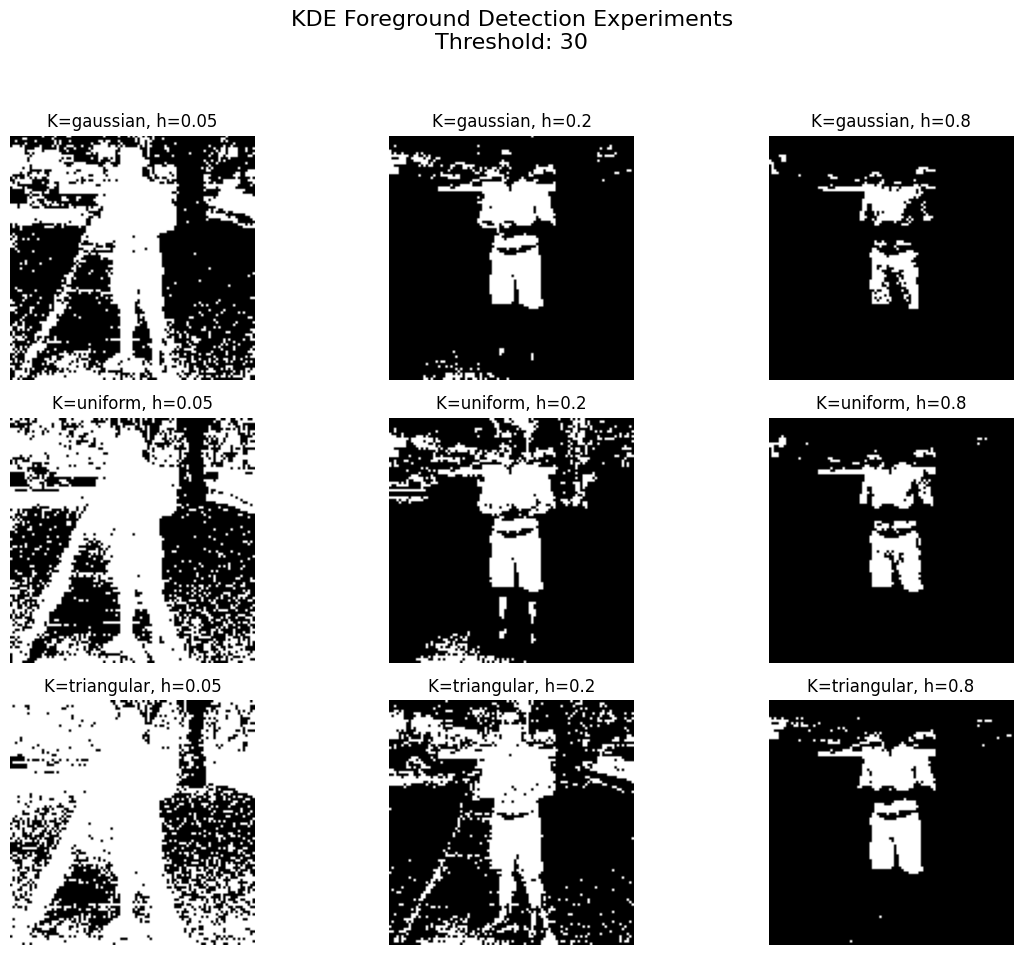

In [3]:
run_experiments()

Explanation of Parameter Selection:

1. Kernel Selection:
    
    Observation: The Gaussian kernel achieved the superior segmentation results compared to Uniform or Triangular kernels.

    Justification: In natural images, sensor noise and lighting variations tend to follow a Normal (Gaussian) distribution. The Gaussian kernel provides a smooth, continuous fall-off for probability density.

    Contrast: The Uniform kernel creates a "hard box" boundary. Pixels are either "in" or "out" with no gradient. This resulted in jagged, pixelated edges around the foreground object in the experiment.

2. Bandwidth Selection:

    Observation: A bandwidth of 0.2 (on normalized [0,1] data) provided the best balance.

    Justification:

        Low Bandwidth (h=0.05): The model became over-sensitive (overfitting). It classified minor noise in the background (like grain or slight shadows) as foreground objects, resulting in a "noisy" mask.

        High Bandwidth (h=0.8): The model became over-smoothed (underfitting). The probability distribution spread out too much, causing the foreground object's colors to be considered "probable" enough to be background. This resulted in the object disappearing or having holes in it.

        Optimal (h=0.2): This value was large enough to smooth out sensor noise but small enough to distinguish the distinct color difference between the object and the background.

Conclusion:
The combination of a Gaussian Kernel with a Bandwidth of 0.2 yields the most robust foreground mask, effectively isolating the object while ignoring background noise.